In [14]:
#imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.formula.api as smf
from statistics import median
from matplotlib.dates import DateFormatter, DayLocator
from matplotlib.dates import DateFormatter, HourLocator
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from scipy.optimize import curve_fit
import scipy.optimize
from sklearn.metrics import mean_squared_error

In [15]:
s1d1df = pd.read_csv('s1d1df.csv')
s1d1df_new = pd.read_csv('s1d1df_new.csv')
s1d2df = pd.read_csv('s1d2df.csv')
s1d2df_new = pd.read_csv('s1d2df_new.csv')

s1d1df_pings = pd.read_csv('s1d1pings.csv')
s1d1df_pings_new = pd.read_csv('s1d1pings_new_first.csv')
s1d2df_pings = pd.read_csv('s1d2pings.csv')
s1d2df_pings_new = pd.read_csv('s1d2pings_new_first.csv')

s1d1df['TIMESTAMP'] = pd.to_datetime(s1d1df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d2df['TIMESTAMP'] = pd.to_datetime(s1d1df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d1df_new['TIMESTAMP'] = pd.to_datetime(s1d1df_new['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d2df_new['TIMESTAMP'] = pd.to_datetime(s1d2df_new['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')

s1d1df_pings['TIMESTAMP'] = pd.to_datetime(s1d1df_pings['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d2df_pings['TIMESTAMP'] = pd.to_datetime(s1d2df_pings['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d1df_pings_new['TIMESTAMP'] = pd.to_datetime(s1d1df_pings_new['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
s1d2df_pings_new['TIMESTAMP'] = pd.to_datetime(s1d2df_pings_new['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')

s1d1df['SDEST'] = s1d1df_new['SDEST'] = s1d1df_new['SDEST'] = s1d1df_pings['SDEST'] = s1d1df_pings_new['SDEST'] = 'CMU'
s1d1df['SACCESS'] = s1d1df_new['SACCESS'] = s1d1df_new['SACCESS'] = s1d1df_pings['SACCESS'] = s1d1df_pings_new['SACCESS'] = 'TMOB'
s1d2df['SDEST'] = s1d2df_new['SDEST'] = s1d2df_new['SDEST'] = s1d2df_pings['SDEST'] = s1d2df_pings_new['SDEST'] = 'AWS'
s1d2df['SACCESS'] = s1d2df_new['SACCESS'] = s1d2df_new['SACCESS'] = s1d2df_pings['SACCESS'] = s1d2df_pings_new['SACCESS'] = 'TMOB'

In [3]:
s1d1df_pings_new

,TIMESTAMP,ping,date,hour,SDEST,SACCESS
0,2024-07-29 12:34:16.756815,2.0,2024-07-29,12,CMU,TMOB
1,2024-07-29 12:34:16.756815,50.0,2024-07-29,12,CMU,TMOB
2,2024-07-29 12:34:16.756815,36.0,2024-07-29,12,CMU,TMOB
3,2024-07-29 12:34:16.756815,38.0,2024-07-29,12,CMU,TMOB
4,2024-07-29 12:34:16.756815,41.0,2024-07-29,12,CMU,TMOB
...,...,...,...,...,...,...
96779,2024-08-01 13:11:27.904257,44.0,2024-08-01,13,CMU,TMOB
96780,2024-08-01 13:11:27.904257,54.0,2024-08-01,13,CMU,TMOB
96781,2024-08-01 13:11:27.904257,51.0,2024-08-01,13,CMU,TMOB
96782,2024-08-01 13:11:27.904257,36.0,2024-08-01,13,CMU,TMOB


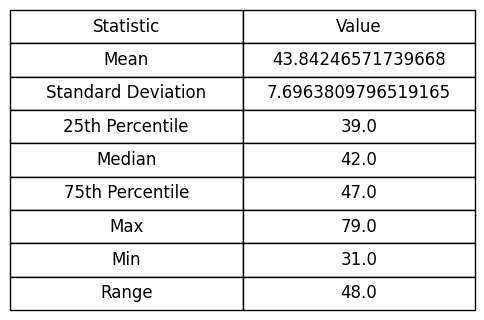

In [12]:
temp_df = pd.concat([s1d1df_pings_new, s1d2df_pings_new], ignore_index=True)

# Calculating the statistics
mean_ping = temp_df['ping'].mean()
percentile_25_ping = temp_df['ping'].quantile(0.25)
median_ping = temp_df['ping'].median()
percentile_75_ping = temp_df['ping'].quantile(0.75)
max_ping = temp_df['ping'].max()
min_ping = temp_df['ping'].min()
range_ping = max_ping - min_ping
std_ping = temp_df['ping'].std()

# Creating a table (dataframe) to store these statistics
summary_table = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Min', 'Range'],
    'Value': [mean_ping, std_ping, percentile_25_ping, median_ping, percentile_75_ping, max_ping, min_ping, range_ping]
})



# Create the plot
fig, ax = plt.subplots(figsize=(3, 2))  # Adjust the figure size as needed

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the plot
table = ax.table(cellText=summary_table.values,
                 colLabels=summary_table.columns,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)  # Adjust the scale to make the table larger

# Display the plot with the table
plt.show()


In [16]:
#necessary functions from the pdutils.py
def readjoin(dn,fn,**kwargs):
    ffn = os.path.join(dn,fn)
    if not os.path.isfile(ffn):
        print("%s does not exist" % ffn)
    return pd.read_csv(ffn,**kwargs)

def readjoin_ts(dn,fn):
    return to_ts_std(readjoin(dn,fn))

def to_ts_std(df):
    return to_ts(df,'%Y-%m-%d %H:%M:%S')

def to_ts(df,fmt):
    import pandas as pd
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'],format=fmt,errors='coerce')
    return df

def ts_lineplot(fdf,ylst,title='',filename='tmp.png',saveon=False,figsize=(15,10),**kwargs):
    # print(title)
    ax = fdf.reset_index().plot(x='TIMESTAMP',y = ylst,title=title,figsize=figsize,**kwargs)
    ax.grid(True)
    return ax

# rolling average

C:\Users\Rohini Pillai\AppData\Local\Temp\ipykernel_25444\2455021078.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()
C:\Users\Rohini Pillai\AppData\Local\Temp\ipykernel_25444\2455021078.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()


"vertical_line_date_1 = pd.Timestamp('2024-03-24')\nplt.axvline(x=vertical_line_date_1, color='r', linestyle='--', linewidth=2)\nvertical_line_date_2 = pd.Timestamp('2024-04-04')\nplt.axvline(x=vertical_line_date_2, color='r', linestyle='--', linewidth=2)"

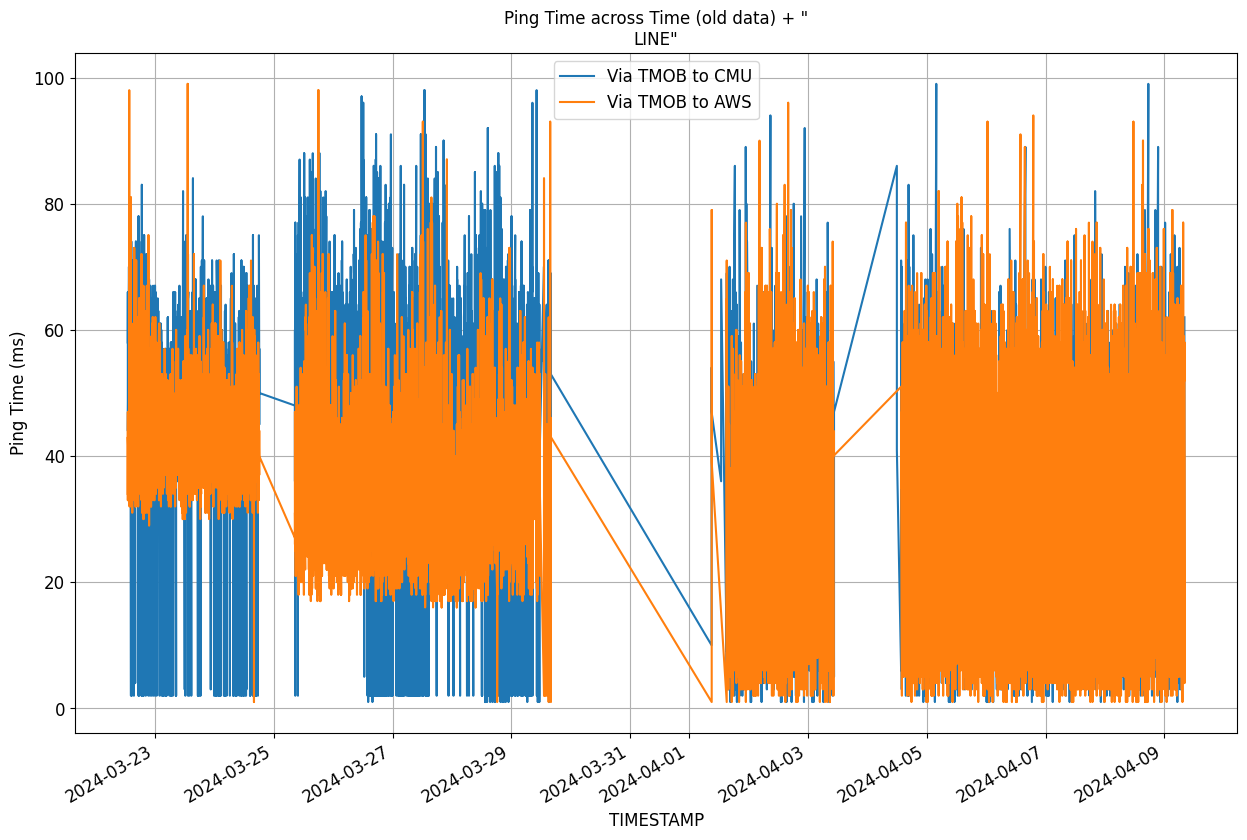

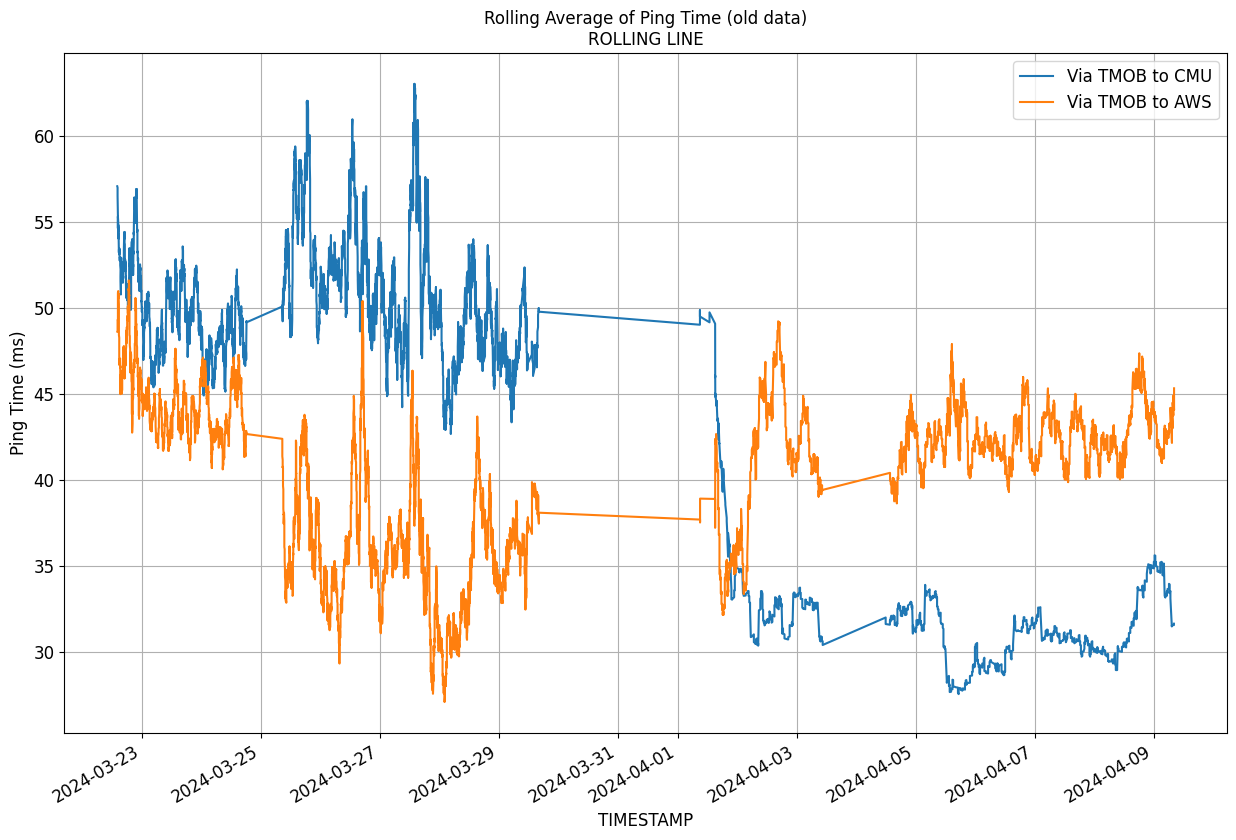

In [17]:
s1d1df_pings['ROLLINGTIME'] = s1d1df_pings['ping'].rolling(window=50).mean()
s1d2df_pings['ROLLINGTIME'] = s1d2df_pings['ping'].rolling(window=50).mean()
s1d1df_pings.reset_index()
s1d2df_pings.reset_index()
main_df = pd.concat([s1d1df_pings, s1d2df_pings], ignore_index=True)

colname='ROLLINGTIME'
# WINDOW=int(np.round(60/7*4,0))
WINDOW=50
#print(WINDOW,main_df.TIME.min(),main_df.TIME.max())
def makeLine(fdf,col,title="Rolling Average (to CMU via TMOB)", filename="tmp.png"):
    sdestlst = list(fdf.SDEST.drop_duplicates())
    sacclst = list(fdf.SACCESS.drop_duplicates())
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    legendlabellst = []
    for SDEST in sdestlst:
        for SACCESS in sacclst:
            fdf1 = fdf[(main_df.SDEST == SDEST) & (main_df.SACCESS == SACCESS)]
            if col == 'ROLLINGTIME':
                fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()
            ax = ts_lineplot(fdf1,[col], ax=ax, title=title,legend=True)
            legendlabellst.append(f"Via {SACCESS} to {SDEST}")
    ax.legend(labels=legendlabellst)
    ax.set_title(title,fontsize=12)
    ax.set_ylabel("Ping Time (ms)")
main_rolling_df = main_df.copy()
makeLine(main_rolling_df,"ping",filename="PING LINE TEST.png",title= 'Ping Time across Time (old data) + "\nLINE"')
makeLine(main_rolling_df,"ROLLINGTIME",filename="ROLLING PING LINE TEST.png",title= 'Rolling Average of Ping Time (old data)' + "\nROLLING LINE")

"""vertical_line_date_1 = pd.Timestamp('2024-03-24')
plt.axvline(x=vertical_line_date_1, color='r', linestyle='--', linewidth=2)
vertical_line_date_2 = pd.Timestamp('2024-04-04')
plt.axvline(x=vertical_line_date_2, color='r', linestyle='--', linewidth=2)"""

C:\Users\Rohini Pillai\AppData\Local\Temp\ipykernel_25444\278074320.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()
C:\Users\Rohini Pillai\AppData\Local\Temp\ipykernel_25444\278074320.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()


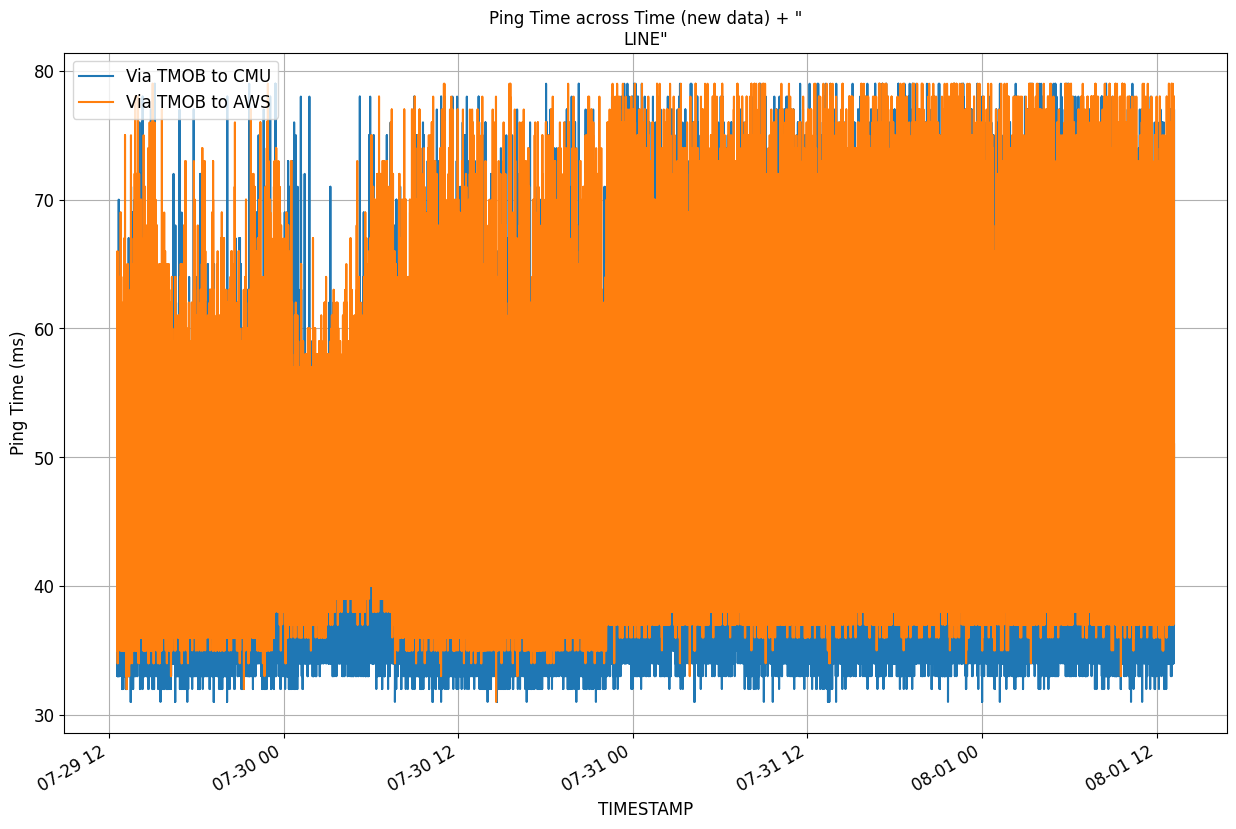

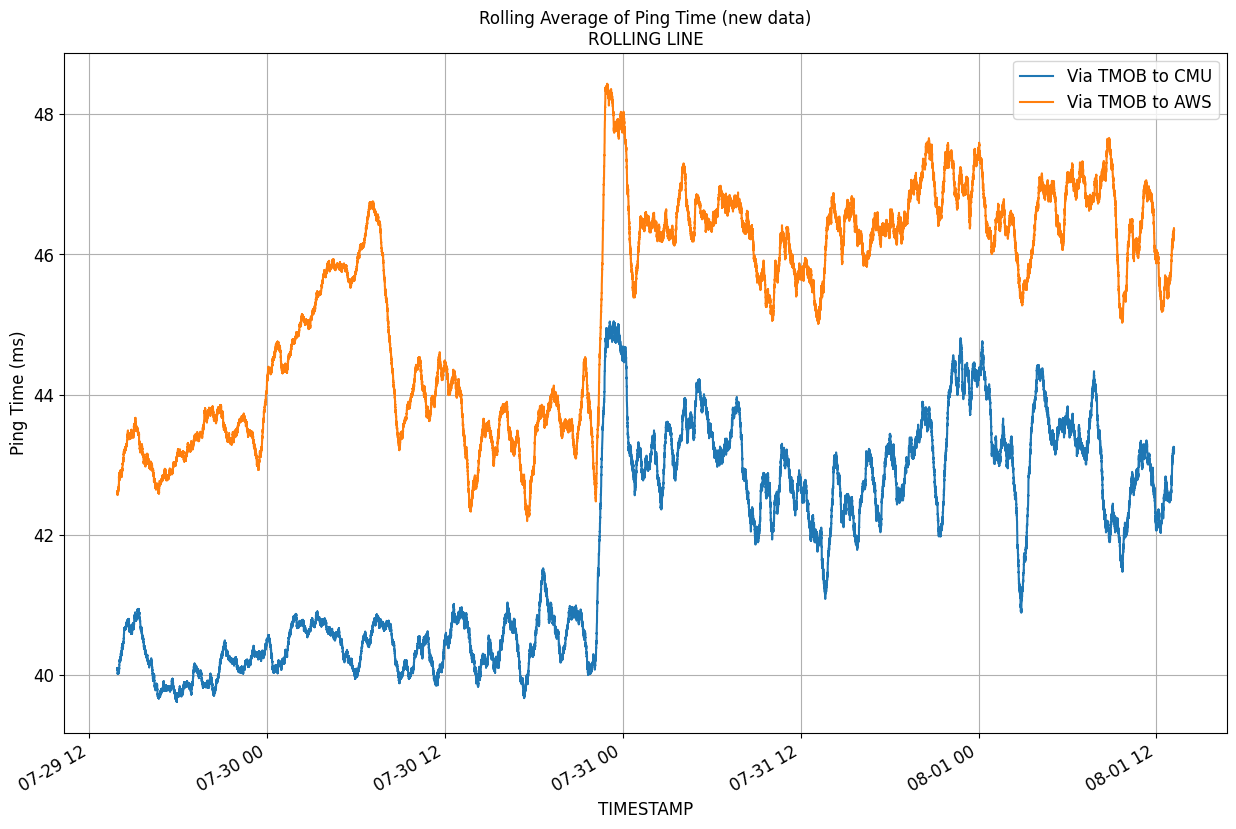

In [11]:
s1d1df_pings_new = s1d1df_pings_new[(s1d1df_pings_new['ping'] > 30) & (s1d1df_pings_new['ping'] < 80)]
s1d2df_pings_new = s1d2df_pings_new[(s1d2df_pings_new['ping'] > 30) & (s1d2df_pings_new['ping'] < 80)]

#s1d1df_pings_new['ROLLINGTIME'] = s1d1df_pings_new['ping'].rolling(window=1000).mean()
#s1d2df_pings_new['ROLLINGTIME'] = s1d2df_pings_new['ping'].rolling(window=1000).mean()
#s1d1df_pings_new.reset_index()
#s1d2df_pings_new.reset_index()
main_df = pd.concat([s1d1df_pings_new, s1d2df_pings_new], ignore_index=True)
#print(main_df)

colname='ROLLINGTIME'
# WINDOW=int(np.round(60/7*4,0))
WINDOW=1000
#print(WINDOW,main_df.TIME.min(),main_df.TIME.max())
def makeLine(fdf,col,title="Rolling Average (to CMU via TMOB)", filename="tmp.png"):
    sdestlst = list(fdf.SDEST.drop_duplicates())
    sacclst = list(fdf.SACCESS.drop_duplicates())
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    legendlabellst = []
    for SDEST in sdestlst:
        for SACCESS in sacclst:
            fdf1 = fdf[(main_df.SDEST == SDEST) & (main_df.SACCESS == SACCESS)]
            if col == 'ROLLINGTIME':
                fdf1[colname] = fdf1['ping'].rolling(WINDOW).mean()
            ax = ts_lineplot(fdf1,[col], ax=ax, title=title,legend=True)
            legendlabellst.append(f"Via {SACCESS} to {SDEST}")
    ax.legend(labels=legendlabellst)
    ax.set_title(title,fontsize=12)
    ax.set_ylabel("Ping Time (ms)")
main_rolling_df = main_df.copy()
makeLine(main_rolling_df,"ping",filename="PING LINE TEST.png",title= 'Ping Time across Time (new data) + "\nLINE"')
makeLine(main_rolling_df,"ROLLINGTIME",filename="ROLLING PING LINE TEST.png",title= 'Rolling Average of Ping Time (new data)' + "\nROLLING LINE")


# ping across time

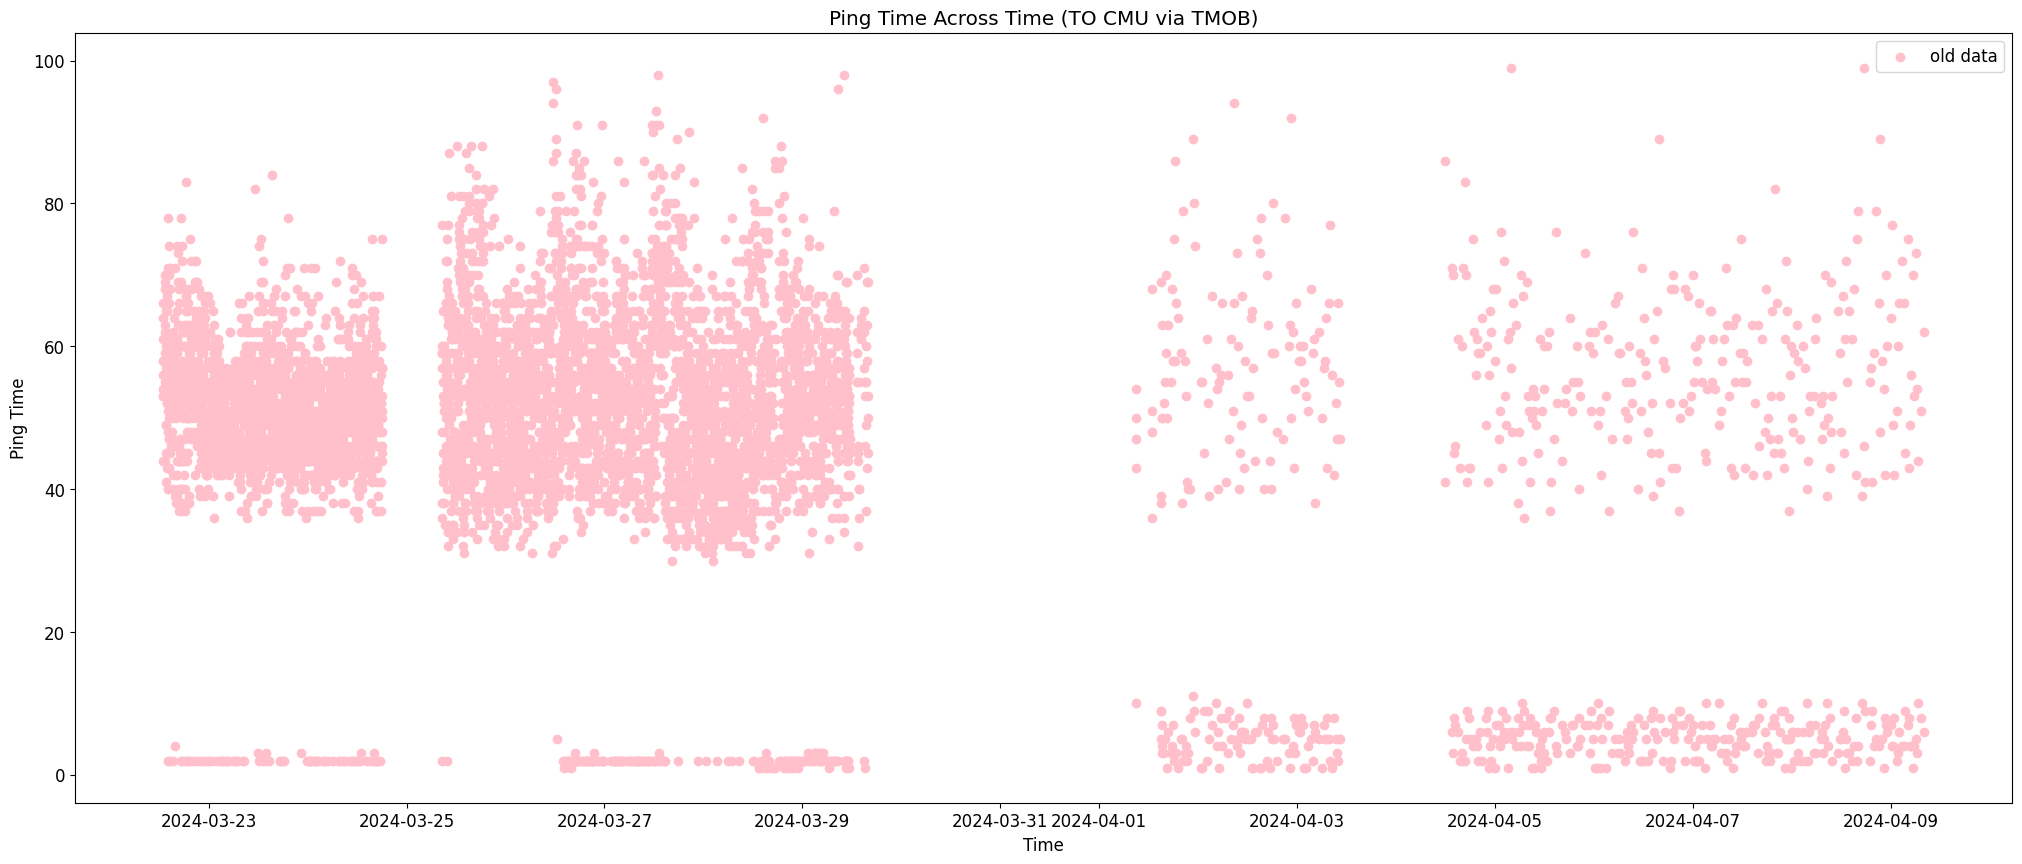

In [7]:
plt.figure(figsize=(25, 10))  # Change width and height here
plt.scatter(s1d1df_pings['TIMESTAMP'], s1d1df_pings['ping'], color='pink', label='old data')
plt.xlabel('Time')
plt.ylabel('Ping Time')
plt.title('Ping Time Across Time (TO CMU via TMOB)')
plt.legend()
plt.show()

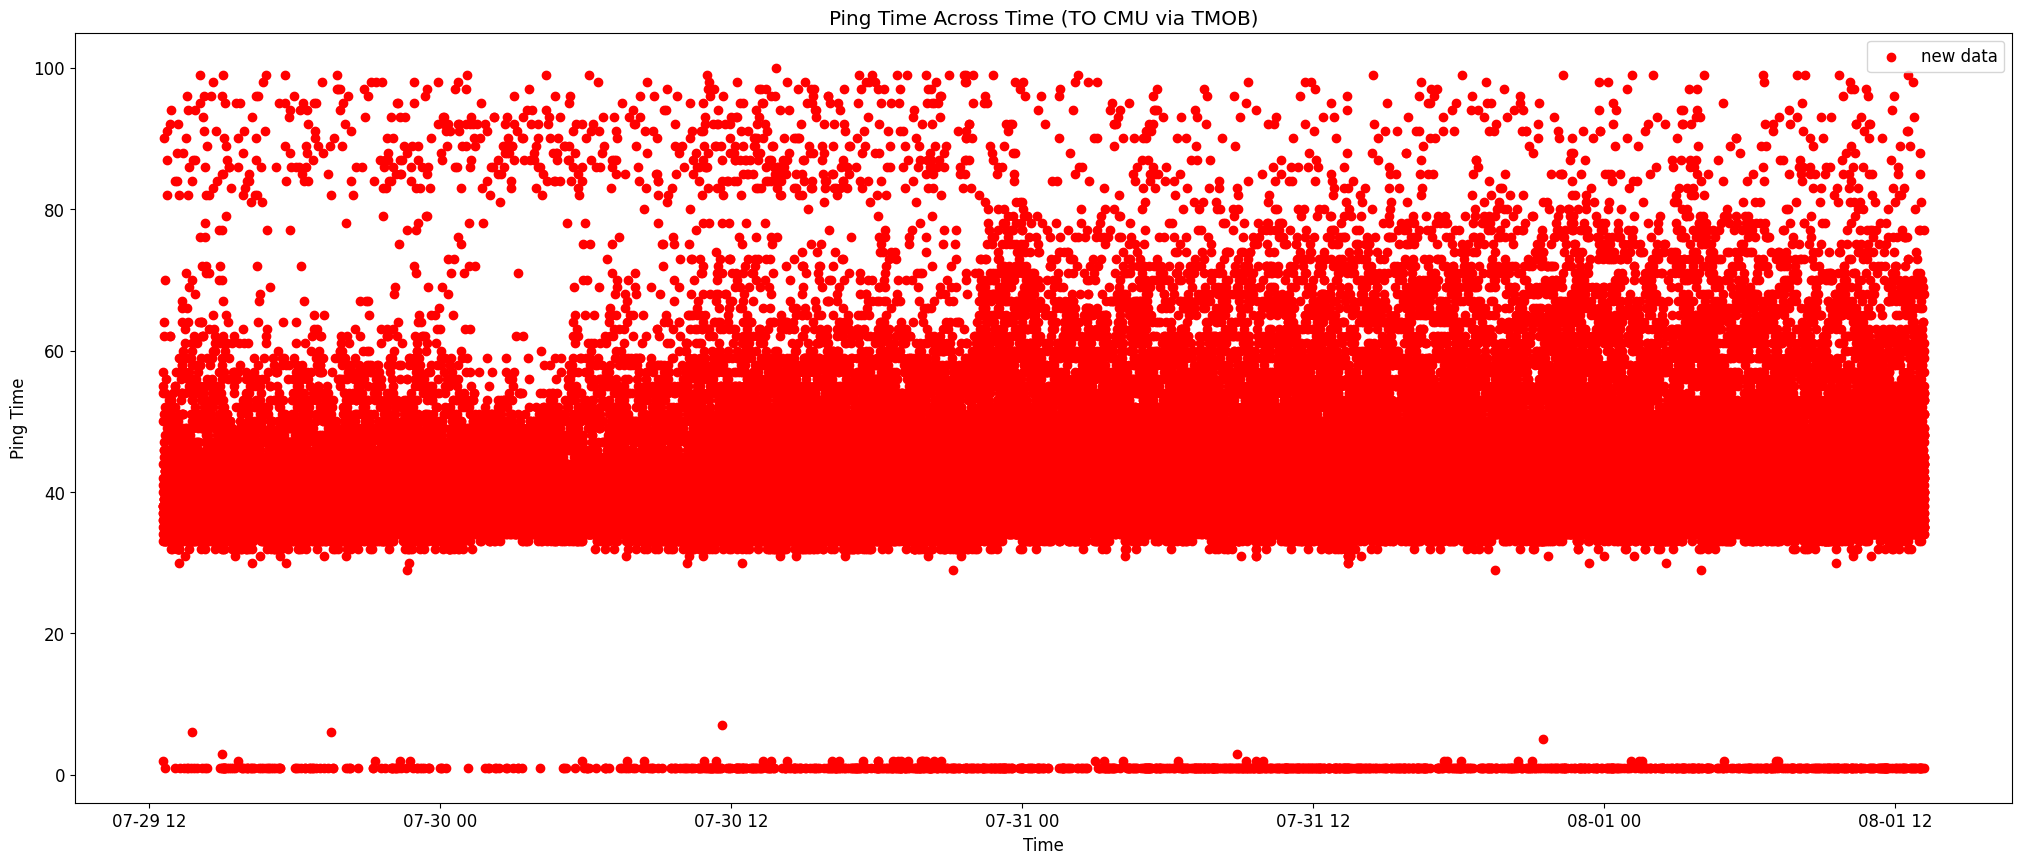

In [8]:
plt.figure(figsize=(25, 10))  # Change width and height here
plt.scatter(s1d1df_pings_new['TIMESTAMP'], s1d1df_pings_new['ping'], color='red', label='new data')
plt.xlabel('Time')
plt.ylabel('Ping Time')
plt.title('Ping Time Across Time (TO CMU via TMOB)')
plt.legend()
plt.show()

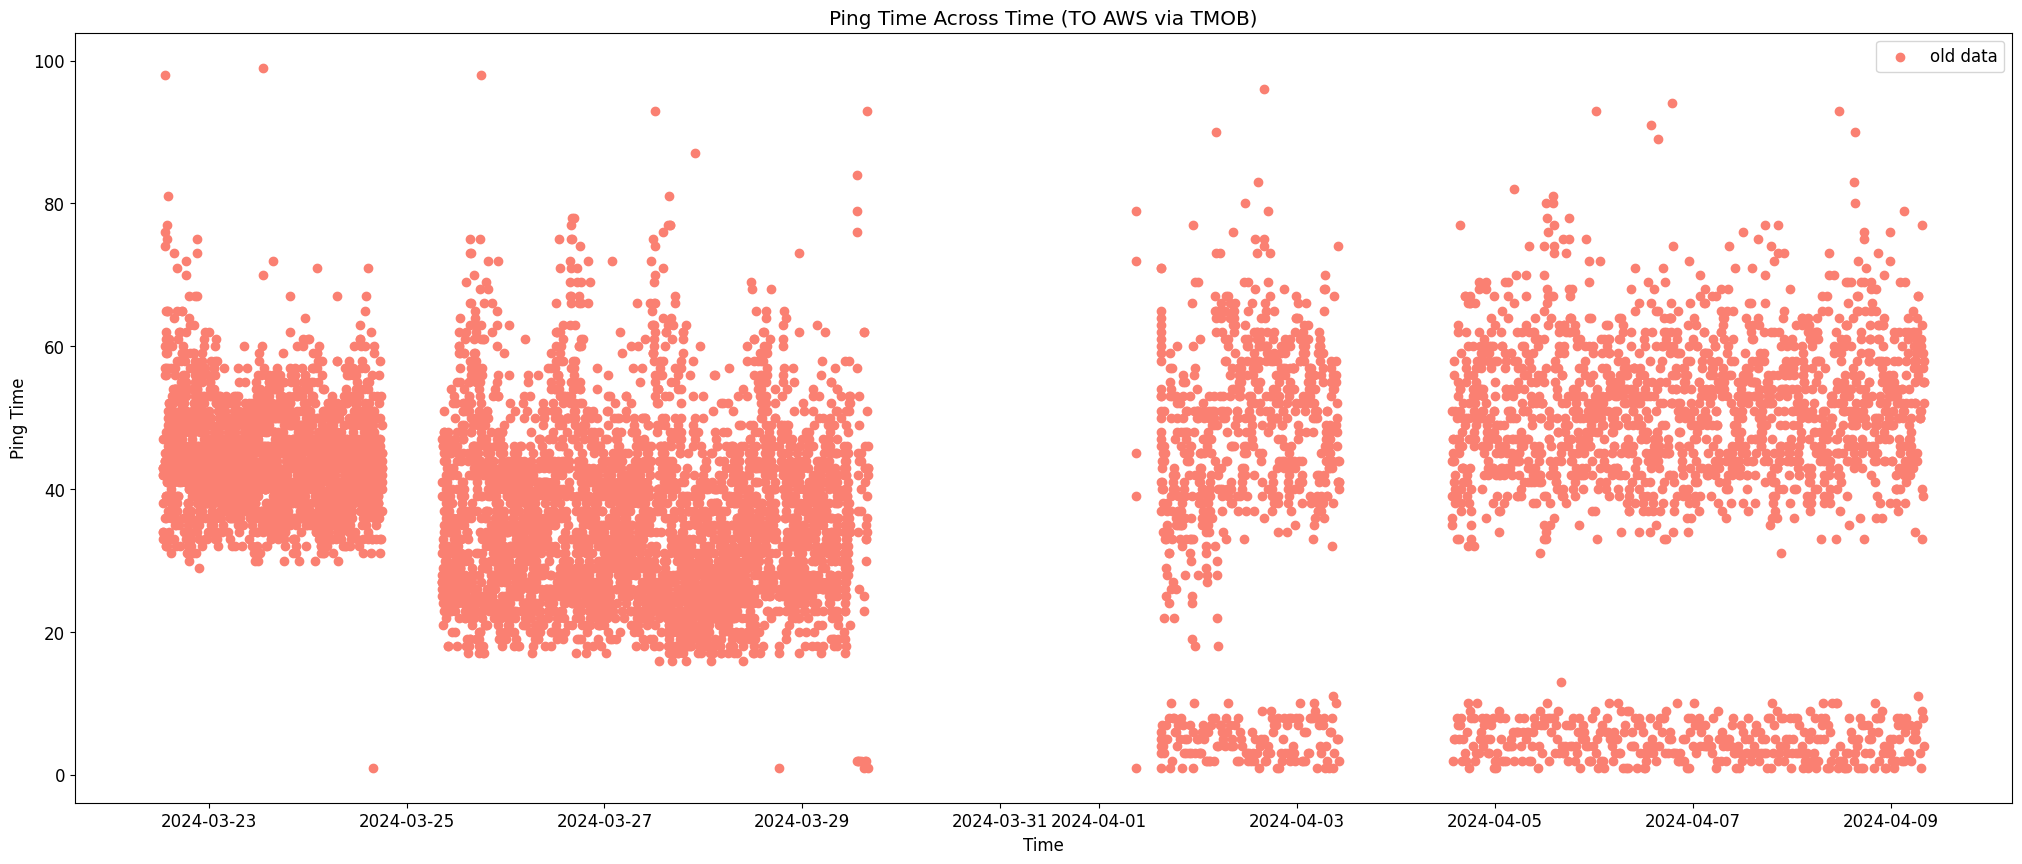

In [9]:
plt.figure(figsize=(25, 10))  # Change width and height here
plt.scatter(s1d2df_pings['TIMESTAMP'], s1d2df_pings['ping'], color='salmon', label='old data')
plt.xlabel('Time')
plt.ylabel('Ping Time')
plt.title('Ping Time Across Time (TO AWS via TMOB)')
plt.legend()
plt.show()

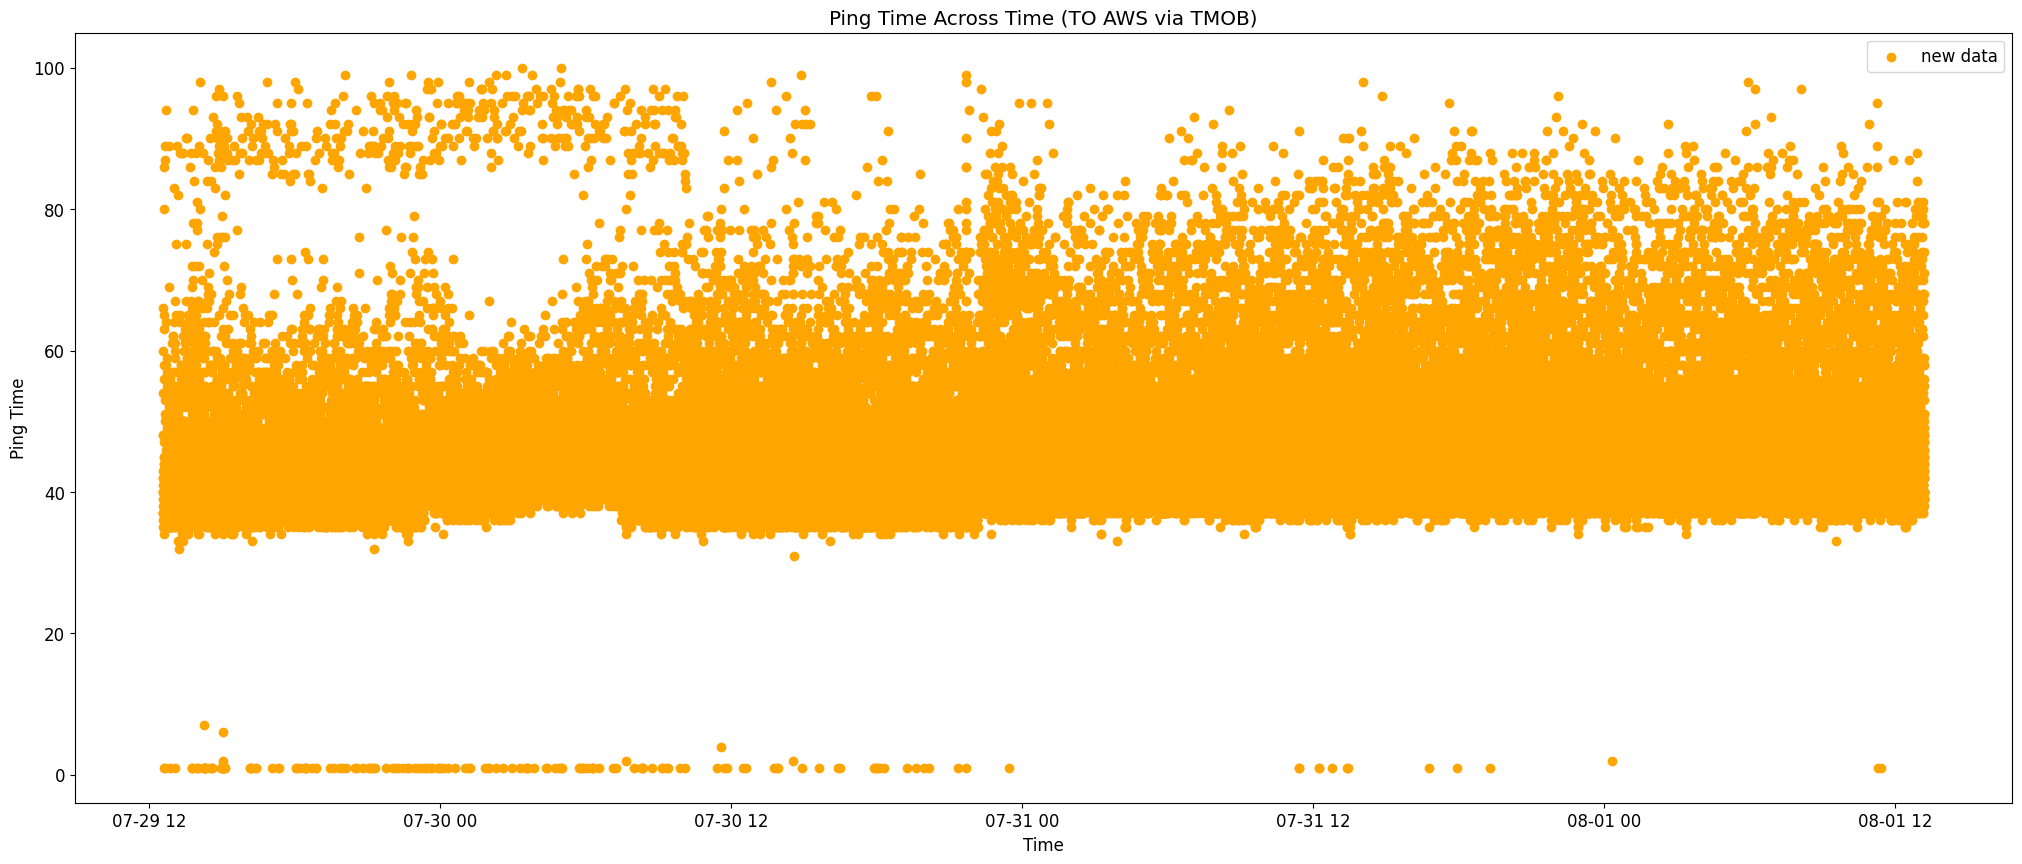

In [10]:
plt.figure(figsize=(25, 10))  # Change width and height here
plt.scatter(s1d2df_pings_new['TIMESTAMP'], s1d2df_pings_new['ping'], color='orange', label='new data')
plt.xlabel('Time')
plt.ylabel('Ping Time')
plt.title('Ping Time Across Time (TO AWS via TMOB)')
plt.legend()
plt.show()

# ping across hops

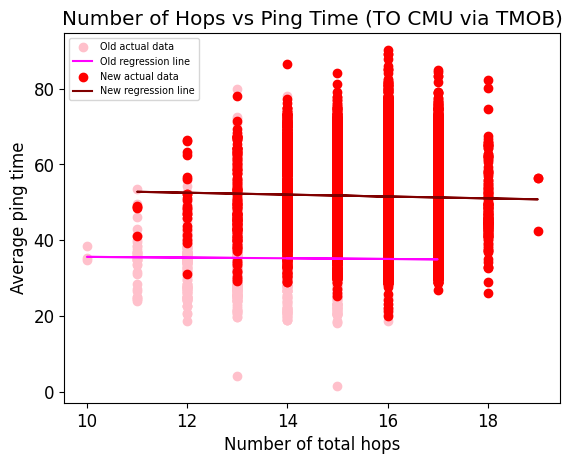

In [11]:
tempdf1 = s1d1df[['NUM_HOPS', 'avg']]
model1 = smf.ols(formula='avg ~ NUM_HOPS', 
                data=tempdf1).fit() 

tempdf2 = s1d1df_new[['NUM_HOPS', 'avg']]
model2 = smf.ols(formula='avg ~ NUM_HOPS', 
                data=tempdf2).fit()


plt.scatter(s1d1df['NUM_HOPS'], s1d1df['avg'], color='pink', label='Old actual data')
predicted = model1.predict(s1d1df['NUM_HOPS'])
plt.plot(s1d1df['NUM_HOPS'], predicted, color='magenta', label='Old regression line')

plt.scatter(s1d1df_new['NUM_HOPS'], s1d1df_new['avg'], color='red', label='New actual data')
predicted = model2.predict(s1d1df_new['NUM_HOPS'])
plt.plot(s1d1df_new['NUM_HOPS'], predicted, color='maroon', label='New regression line')

plt.xlabel('Number of total hops')
plt.ylabel('Average ping time')
plt.title('Number of Hops vs Ping Time (TO CMU via TMOB)')
plt.legend(fontsize='xx-small')
plt.show()

In [12]:
tempdf1 = s1d2df[['NUM_HOPS', 'avg']]
model1 = smf.ols(formula='avg ~ NUM_HOPS', 
                data=tempdf1).fit() 

tempdf2 = s1d2df_new[['NUM_HOPS', 'avg']]
model2 = smf.ols(formula='avg ~ NUM_HOPS', 
                data=tempdf2).fit()


plt.scatter(s1d2df['NUM_HOPS'], s1d2df['avg'], color='salmon', label='Old actual data')
predicted = model1.predict(s1d2df['NUM_HOPS'])
plt.plot(s1d2df['NUM_HOPS'], predicted, color='indianred', label='old regression line')

plt.scatter(s1d2df_new['NUM_HOPS'], s1d2df_new['avg'], color='orange', label='New actual data')
predicted = model2.predict(s1d2df_new['NUM_HOPS'])
plt.plot(s1d2df_new['NUM_HOPS'], predicted, color='brown', label='New regression line')

plt.xlabel('Number of total hops')
plt.ylabel('Average ping time')
plt.title('Number of Hops vs Ping Time (To AWS via TMOB)')
plt.legend(fontsize='xx-small')
plt.show()

ValueError: negative dimensions are not allowed

# hops

In [ ]:
hops_df = s1d1df['NUM_HOPS'].value_counts().reset_index()
hops_df.columns = ['hops_amount', 'frequency']
print(hops_df)
plt.scatter(hops_df['hops_amount'], hops_df['frequency'], color='pink', label='Old data')

hops_df = s1d1df_new['NUM_HOPS'].value_counts().reset_index()
hops_df.columns = ['hops_amount', 'frequency']
print(hops_df)
plt.scatter(hops_df['hops_amount'], hops_df['frequency'], color='red', label='New data')
plt.legend()

In [ ]:
hops_df = s1d2df['NUM_HOPS'].value_counts().reset_index()
hops_df.columns = ['hops_amount', 'frequency']
print(hops_df)
plt.scatter(hops_df['hops_amount'], hops_df['frequency'], color='salmon', label='Old data')

hops_df = s1d2df_new['NUM_HOPS'].value_counts().reset_index()
hops_df.columns = ['hops_amount', 'frequency']
print(hops_df)
plt.scatter(hops_df['hops_amount'], hops_df['frequency'], color='orange', label='New data')
plt.legend()